## Download Data

You can access the AHN data (Actueel Hoogtebestand Nederland) trough their [website](https://www.ahn.nl/ahn-4) and de [ESRI Explorer](https://hub.arcgis.com/maps/esrinl-content::ahn4-download-kaartbladen-1/explore). To download, simply click on one of the tiles and select the data you want to download. In this case we are going to work with a **DTM 5m** resolution.

## Clip the area

#### Import the necesary libraries



In [102]:
import pickle
import trimesh as tm
import math
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import embreex

In [ ]:
## load result from previous notebook using pickle
with open('mesh.pkl','rb') as file:
    mesh = pickle.load(file)

mesh.show()

In [227]:
## Use mathematical spherical coordinateshttps://en.wikipedia.org/wiki/Spherical_coordinate_system
T=180 # Theta counter - Azimuth Angles
K=45 # Phi counter - Elevation Angles
r=10 #size of dome
hemisphereVertices = []

for t in range (T):
    for k in range(K):
        theta = (float(t/T))*math.pi*2
        phi= (float(k/K))*math.pi/2
        x = r*math.sin(phi)*math.cos(theta)
        y = r*math.sin(phi)*math.sin(theta)
        z = r*math.cos(phi)
        hSVertex = [x,y,z]
        #print(theta,phi,z)

        hemisphereVertices.append(hSVertex)
        
#hemisphereVertices

In [228]:
domePC = o3d.geometry.PointCloud()
domePC.points = o3d.utility.Vector3dVector(hemisphereVertices)
o3d.visualization.draw_geometries([domePC])

### Now lets do it with NP Meshgrids

In [18]:
nt,nk=(180,45)
thetaArray = np.linspace(0,2*np.pi,nt) 
phiArray = np.linspace(0,np.pi/2,nk)

thetaGrid, phiGrid = np.meshgrid(thetaArray,phiArray) 

array([[0.        , 0.03510159, 0.07020319, ..., 6.21298212, 6.24808371,
        6.28318531],
       [0.        , 0.03510159, 0.07020319, ..., 6.21298212, 6.24808371,
        6.28318531],
       [0.        , 0.03510159, 0.07020319, ..., 6.21298212, 6.24808371,
        6.28318531],
       ...,
       [0.        , 0.03510159, 0.07020319, ..., 6.21298212, 6.24808371,
        6.28318531],
       [0.        , 0.03510159, 0.07020319, ..., 6.21298212, 6.24808371,
        6.28318531],
       [0.        , 0.03510159, 0.07020319, ..., 6.21298212, 6.24808371,
        6.28318531]])

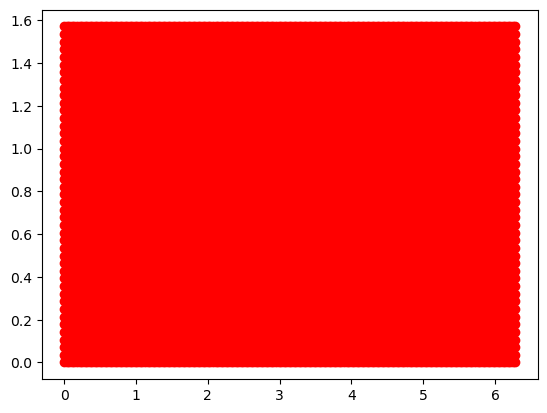

In [20]:
plt.plot(thetaGrid, phiGrid, marker='o', color='r', linestyle='none')
plt.show()

In [70]:
def Spherical2Cartesian (r,theta,phi):
    x = r*np.sin(phi)*np.cos(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(phi)
    return np.array([x,y,z])

CartesianPoints = Spherical2Cartesian(r,thetaGrid,phiGrid)
CartesianPointsR= CartesianPoints.reshape(3,-1).T # reshape and transpose
CartesianPointsT = CartesianPoints.T
CartesianPointsT.shape


(180, 45, 3)

In [229]:
#Visualize Points in 3D
domeMesh = o3d.geometry.PointCloud()
domeMesh.points = o3d.utility.Vector3dVector(CartesianPointsR)
o3d.visualization.draw_geometries([domeMesh])

### create Rays for all points in dome

In [ ]:
## http://www.open3d.org/docs/latest/tutorial/geometry/ray_casting.html

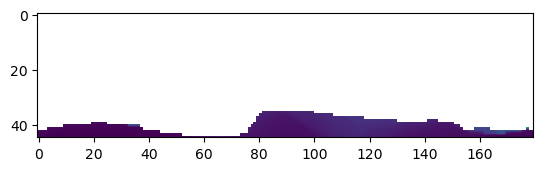

In [303]:
vertex = np.array(mesh.vertices[650]+[0,0,1])
rayOrigins = np.broadcast_to(vertex, CartesianPointsT.shape)
rayDirections=(CartesianPointsT)
raysOD = np.concatenate((rayOrigins,rayDirections), axis=2)

o3dMesh = o3d.io.read_triangle_mesh('../Results/mesh.obj')

o3dMeshLegacy = o3d.t.geometry.TriangleMesh.from_legacy(o3dMesh)   
scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(o3dMeshLegacy)

o3dRayGrid=o3d.core.Tensor(raysOD,dtype=o3d.core.Dtype.Float32)

ans = scene.cast_rays(o3dRayGrid)

# Visualize the hit distance (depth)
SVimage= ans['t_hit'].numpy().T
plt.imshow(SVimage)

In [311]:
gamma=np.where(SVimage != np.inf)[0][:]
SVF=(1-np.sum((np.sin(gamma))/K,axis=0))/(2*np.pi)
SVF


0.7760384870225651

In [134]:
# vertex = np.array([0,0,0])

rayDirections=(CartesianPointsT-vertex).reshape(-1,3)
rayOrigins = np.broadcast_to(vertex, rayDirections.shape)
# for t in range(T):
#     for k in range(K):
#         hsPoint = CartesianPointsT[t,k,:]
#         ray = (vertex,hsPoint)
hitLocations,indexRay, indexTriangle= mesh.ray.intersects_location(ray_origins=rayOrigins,ray_directions=rayDirections)

hitLocations.shape,indexRay.shape
# rayDirections.shape




((16200, 3), (16200,))

In [138]:
indexTriangle, indexRay = tm.ray.ray_triangle.RayMeshIntersector(mesh).intersects_id(ray_origins=rayOrigins,ray_directions=rayDirections,multiple_hits=True,return_loctaions=False)

indexTriangle, indexRay



(array([734, 737, 734, ..., 737, 734, 737], dtype=int64),
 array([   0,    0,    1, ..., 8098, 8099, 8099], dtype=int64))

### using O3D

In [ ]:
# mesh to obj
f=mesh.export(file_obj='../Results/mesh.obj',file_type='obj')
f

In [234]:
#read obj
o3dMesh = o3d.io.read_triangle_mesh('../Results/mesh.obj')

o3dMeshLegacy = o3d.t.geometry.TriangleMesh.from_legacy(o3dMesh)   
scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(o3dMeshLegacy)

vertex=np.array(mesh.vertices[456]).reshape(1,3)



K=45

# for t in range (T):
t=40
hit_phi=np.pi/2
i=0
t_rays=np.zeros((K,6))
for k in range(K):
    
    theta = (float(t/T))*math.pi*2
    phi= (float(k/K))*math.pi/2
    x = r*math.sin(phi)*math.cos(theta)
    y = r*math.sin(phi)*math.sin(theta)
    z = r*math.cos(phi)
    hSVertex = np.array([x,y,z]).reshape(1,3)
    t_rays[k,:]=np.concatenate((vertex,hSVertex-vertex),axis=1)
    
    # hit = tm.ray.ray_triangle.RayMeshIntersector(mesh).intersects_any(ray_origins=vertex,ray_directions=hSVertex-vertex) #multiple_hits=False,return_locations=False)
    # triangleIndex=tm.ray.ray_triangle.RayMeshIntersector(mesh).intersects_first(ray_origins=vertex,ray_directions=hSVertex-vertex) 
    # hit = (triangleIndex != -1)
    # if hit[0]: #and phi > 0:
    #     hit_phi=phi
    #     print(hit_phi)
    #     i =i+1
    #     print (i)
    #     # break
    
o3dRays=o3d.core.Tensor(t_rays,dtype=o3d.core.Dtype.Float32)

# Compute the ray intersections.
ans = scene.cast_rays(o3dRays)




AttributeError: 'open3d.cpu.pybind.t.geometry.TriangleMesh' object has no attribute 'vertices'

In [221]:
o3

{'t_hit': [-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0]
 Tensor[shape={45}, stride={1}, Float32, CPU:0, 0x22908278660],
 'geometry_ids': [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 Tensor[shape={45}, stride={1}, UInt32, CPU:0, 0x22908277820],
 'primitive_ids': [737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737 737]
 Tensor[shape={45}, stride={1}, UInt32, CPU:0, 0x22908277fa0],
 'primitive_normals': [[-0.110158 0.518571 0.847909],
  [-0.110158 0.518571 0.847909],
  [-0.110158 0.518571 0.847909],
  [-0.110158 0.518571 0.847909],
  [-0.110158 0.518571 0.847909],
  [-0.110158 0.518571 0.847909],
  [-0.110158 0.518571 0.847909],
  [-0.110158

TypeError: Invalid shape (45,) for image data

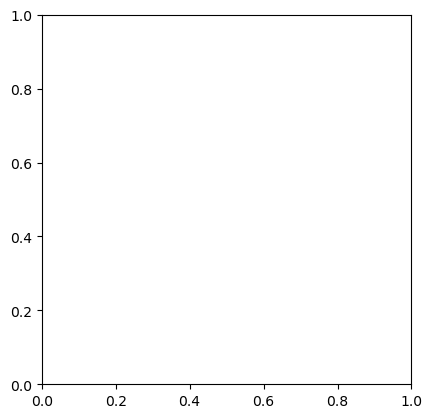

In [222]:
# Visualize the hit distance (depth)
plt.imshow(ans['t_hit'].numpy())

TypeError: Invalid shape (45,) for image data

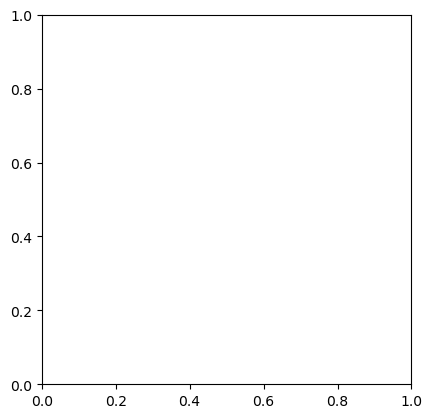

In [ ]:
# Visualize the hit distance (depth)
plt.imshow(ans['t_hit'].numpy())

In [ ]:
# tempMesh = mesh.copy()
f=mesh.export(file_obj='../Results/mesh.obj',file_type='obj')
f

In [183]:
o3dMesh = o3d.io.read_triangle_mesh('../Results/mesh.obj')

o3dMeshLegacy = o3d.t.geometry.TriangleMesh.from_legacy(o3dMesh)

In [184]:
scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(o3dMeshLegacy)

0

In [185]:
# Rays are 6D vectors with origin and ray direction.
# rays = o3d.core.Tensor([[0.5, 0.5, 10, 0, 0, -1], [-1, -1, -1, 0, 0, -1]],                       dtype=o3d.core.Dtype.Float32)


In [187]:
rays.type()

AttributeError: 'open3d.cpu.pybind.core.Tensor' object has no attribute 'type'